# Generate mock data

This tutorial illustrates how to make generate mock observed spectra using `fakeit` - like interface
as proposed by XSPEC.

In [1]:
import numpyro
from jax.config import config

config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")
#numpyro.set_host_device_count(4)

Let's build a model we want to fake

In [2]:
from jaxspec.model.additive import Powerlaw, Blackbodyrad
from jaxspec.model.multiplicative import Tbabs

model = Tbabs() * (Powerlaw() + Blackbodyrad())

Let's load an observation with the instrumental setup which should be applied

In [3]:
from jaxspec.data.util import example_observations as obs_list

obs = obs_list["PN"]

Ideally you would like to load your data

```python
from jaxspec.data.observation import Observation
obs = Observation.from_pha_file("my_data.pha", low_energy=0.3, high_energy=10)
```

Let's do fakeit for a bunch of parameters

In [4]:
from numpy.random import default_rng

rng = default_rng(42)

num_params = 10000
parameters = {
    "tbabs_1": {"N_H": rng.uniform(0.1, 0.4, size=num_params)},
    "powerlaw_1": {"alpha": rng.uniform(1, 3, size=num_params), "norm": rng.exponential(10 ** (-0.5), size=num_params)},
    "blackbodyrad_1": {"kT": rng.uniform(0.1, 3.0, size=num_params), "norm": rng.exponential(10 ** (-3), size=num_params)},
}

And now we can fakeit!

In [5]:
from jaxspec.data.util import fakeit_for_multiple_parameters
spectra = fakeit_for_multiple_parameters(obs, model, parameters)

Let's plot the results

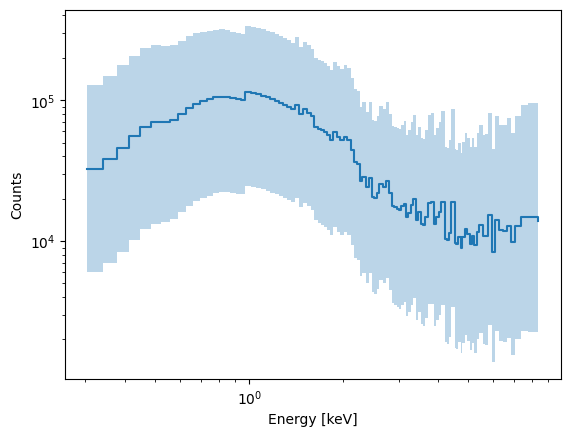

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.step(obs.out_energies[0], np.median(spectra, axis=0), where="post", label=r"median")

plt.fill_between(
    obs.out_energies[0],
    *np.percentile(spectra, [14, 86], axis=0),
    alpha=0.3,
    step="post",
    label=r"$1-\sigma$ bands",
)

plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.loglog();

This could be run on the GPU so it goes even faster! Or be properly parallelized to run on multiple cores of your CPU, this will be implemented at some point. Stay tuned!